In [2]:
import warnings
warnings.filterwarnings('ignore')


import re
from owlready2 import get_ontology
from nltk.stem import PorterStemmer
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import joblib
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np 
import joblib
from nltk.stem import PorterStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [3]:
from rdflib import Graph

g = Graph()
g.parse("MaCOntoFile.owl", format="xml")  # Try "turtle" if XML fails
print(len(g))  # Check the number of triples

8958


In [4]:
# Query for OWL classes
query_classes = """
SELECT ?class WHERE {
    ?class a owl:Class .
}
"""

# Execute the query
for row in g.query(query_classes):
    print(row[0])  # Print the class URI


N8b477a5e6eb5420b8339af083cb19213
N41b01e3c4914440583d671c6e0b66dbc
Nbed2d0cfca984b23ab71c494ddc6c660
N4c153ee790f54871a0c025b6994404ff
N2ec3f4e0941c48df81a99aa689e1a446
Nc892ad2f1dfa4e9a9ad2139a0f16f762
N4e6009867e754319bcaba7b3168124d1
N908f7629299248bf9a348c59cab31ab4
N287cb5ef7d3340db9a26f386653c53fe
Nc8794c4b449644358c040f2598cbb8b0
N3364f09ae2a44f1ea7944aacbbb24c7d
Nfd0d9bd7024446e5a5c66f35d22d90ed
N533b3b1fdadb4b48931497fb11a50596
Nd6c5b6fd90fd45f1afbb58f0b033c551
Nea138b294b9248979319579a5a954475
N5bfaa6e1cc794d32ab39f63386187736
Nee8f41179c8243658ab7445bee2c6019
Ndc1b4af8e99c4983b5c235418450bd0a
http://www.semanticweb.org/hp/ontologies/2018/11/untitled-ontology-38#AbioticStress
http://www.semanticweb.org/hp/ontologies/2018/11/untitled-ontology-38#Acreage
http://www.semanticweb.org/hp/ontologies/2018/11/untitled-ontology-38#AgriculturalInstitute
http://www.semanticweb.org/hp/ontologies/2018/11/untitled-ontology-38#Agronomical
http://www.semanticweb.org/hp/ontologies/2018/11/unt

In [148]:
# Define RDF, RDFS, and OWL prefixes
from rdflib import URIRef



query_relations = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT ?property ?domain ?range WHERE {
    ?property a ?type .
    FILTER (?type IN (rdf:Property, owl:ObjectProperty, owl:DatatypeProperty))
    
    OPTIONAL { ?property rdfs:domain ?domain . }
    OPTIONAL { ?property rdfs:range ?range . }
}
"""

# Execute query
results = g.query(query_relations)

pattern_collector = []

def get_local_name(uri):
    """ Extracts the local name from a URI (removes namespace). """
    if isinstance(uri, URIRef):
        return uri.split("#")[-1] if "#" in uri else uri.split("/")[-1]
    return uri  # Return as-is if it's not a URIRef

# Execute query
for row in results:
    prop_name = get_local_name(row.property)
    domain_name = get_local_name(row.domain) if row.domain else "None"
    range_name = get_local_name(row.range) if row.range else "None"
    
    print(f"Property: {prop_name}, Domain: {domain_name}, Range: {range_name}")
    pattern_collector.append(f'{domain_name}, {prop_name}, {range_name}')

# Debugging: Check if any results are returned
if len(results) == 0:
    print("No properties found. Check ontology content and namespaces.")


print(len(pattern_collector))

Property: adequate, Domain: None, Range: None
Property: adequate_for, Domain: None, Range: None
Property: affects, Domain: Fertilizers, Range: Corn
Property: affects, Domain: Fertilizers, Range: Crop
Property: affects, Domain: Fertilizers, Range: Maize
Property: affects, Domain: Fertilizers, Range: MaizeGrass
Property: affects, Domain: Fertilizers, Range: MaizeCrop
Property: affects, Domain: Fertilizers, Range: N8b477a5e6eb5420b8339af083cb19213
Property: affects, Domain: Fertilizers, Range: N4631163bef8e484e8fbba88e729cae42
Property: affects, Domain: Fertilizers, Range: N2d8944154221428180f1e94f959eedf7
Property: affects, Domain: Manures, Range: Corn
Property: affects, Domain: Manures, Range: Crop
Property: affects, Domain: Manures, Range: Maize
Property: affects, Domain: Manures, Range: MaizeGrass
Property: affects, Domain: Manures, Range: MaizeCrop
Property: affects, Domain: Manures, Range: N8b477a5e6eb5420b8339af083cb19213
Property: affects, Domain: Manures, Range: N4631163bef8e484e

'fertilizer'

In [152]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
# initializaing lemmatizer... 
w_lemmer = WordNetLemmatizer()


# romove same work occuring side by side
def remove_consecutive_duplicates(words):
    result = []
    for i, word in enumerate(words):
        # Add the word only if it's not the same as the previous word
        if i == 0 or word != words[i - 1]:
            result.append(word)
    return result

# clean single doc
def clean_doc(doc, lemma):
    # remove empty list
    clean = [samp for samp in doc.split(' ') if samp != '']

    # remove underscore
    clean_doc = []
    cln_data = ''
    for cln in clean: 
        cln_data = ' '.join(cln.split('_'))
        clean_doc.extend(cln_data.split(' '))

    # making first letter capital...
    clean_doc = ' '.join([cln_d[0].upper() + cln_d[1:] for cln_d in clean_doc])


    # Splitting based on Cap Text
    clean_doc = re.findall(r'[A-Z][a-z]*|[a-z]*[A-Z][a-z]*', clean_doc)
    # print(text)
    # remove side by side reoccuring word
    final_clean_document  = remove_consecutive_duplicates(clean_doc)    
    # convert all to small cap

    if lemma: 
        final_clean_document = [w_lemmer.lemmatize(doc.lower()) for doc in final_clean_document]
    else: 
        final_clean_document = [doc.lower() for doc in final_clean_document]
        
    return final_clean_document

# looping through the document in the 
# ontology file... 
def clean_docs(documents): 
    document = []
    for doc in documents:
        document.append(clean_doc(doc, False))
        
    return document

clean_docs = clean_docs(pattern_collector)
clean_docs[:5]

[['none', 'adequate', 'none'],
 ['none', 'adequate', 'for', 'none'],
 ['fertilizers', 'affects', 'corn'],
 ['fertilizers', 'affects', 'crop'],
 ['fertilizers', 'affects', 'maize']]

In [7]:
# generating Structural table... 
data = {'ont_doc': pattern_collector, 'clean_doc': clean_docs}
dataset = pd.DataFrame(data)
dataset

,ont_doc,clean_doc
0,"None, adequate, None","[none, adequate, none]"
1,"None, adequate_for, None","[none, adequate, for, none]"
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]"
3,"Fertilizers, affects, Crop","[fertilizers, affects, crop]"
4,"Fertilizers, affects, Maize","[fertilizers, affects, maize]"
...,...,...
1662,"Fertilizer_Application_Methods, isUsedInHillyA...","[fertilizer, application, methods, is, used, i..."
1663,"AerialApplicationMethod, isUsedInHillyAreas, s...","[aerial, application, method, is, used, in, hi..."
1664,"SoilAmendmentMaterials, requiresFertilizer, st...","[soil, amendment, materials, requires, fertili..."
1665,"Irrigation_Methods, suitabilityOfIrrigationMet...","[irrigation, methods, suitability, of, irrigat..."


In [8]:
def clean_noise(text):
    pattern = r"N[a-fA-F0-9]{32}"
    # Check if the pattern exists in the string
    match = re.search(pattern, text)
    if match: return True
    else: return False


    # dataset['domain'] , dataset['property'] , dataset['range'] = dataset['ont_doc'].apply(lambda x: x.split(','))
dataset[['domain', 'property', 'range']] = dataset['ont_doc'].str.split(',', expand=True)
dataset.head(3)

,ont_doc,clean_doc,domain,property,range
0,"None, adequate, None","[none, adequate, none]",None,adequate,None
1,"None, adequate_for, None","[none, adequate, for, none]",None,adequate_for,None
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",Fertilizers,affects,Corn


In [9]:
# extracting table with both domain and range non non....
dataset = dataset[(dataset['domain'] != 'None') & (dataset['range'] != ' None')]
dataset.head(2)

,ont_doc,clean_doc,domain,property,range
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",Fertilizers,affects,Corn
3,"Fertilizers, affects, Crop","[fertilizers, affects, crop]",Fertilizers,affects,Crop


In [10]:
pattern = r"N[a-fA-F0-9]{32}"

filtered_dataset = dataset[~dataset['ont_doc'].str.contains(pattern, na=False, regex=True)]
print(filtered_dataset.shape)
filtered_dataset.head(3)

(860, 5)


,ont_doc,clean_doc,domain,property,range
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",Fertilizers,affects,Corn
3,"Fertilizers, affects, Crop","[fertilizers, affects, crop]",Fertilizers,affects,Crop
4,"Fertilizers, affects, Maize","[fertilizers, affects, maize]",Fertilizers,affects,Maize


In [11]:
dataset = filtered_dataset[['ont_doc', 'clean_doc']]
dataset.head(3)

,ont_doc,clean_doc
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]"
3,"Fertilizers, affects, Crop","[fertilizers, affects, crop]"
4,"Fertilizers, affects, Maize","[fertilizers, affects, maize]"


In [12]:
dataset['final_doc'] = dataset.clean_doc.apply(lambda x: ' '.join(x))
dataset

,ont_doc,clean_doc,final_doc
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",fertilizers affects corn
3,"Fertilizers, affects, Crop","[fertilizers, affects, crop]",fertilizers affects crop
4,"Fertilizers, affects, Maize","[fertilizers, affects, maize]",fertilizers affects maize
5,"Fertilizers, affects, MaizeGrass","[fertilizers, affects, maize, grass]",fertilizers affects maize grass
6,"Fertilizers, affects, MaizeCrop","[fertilizers, affects, maize, crop]",fertilizers affects maize crop
...,...,...,...
1662,"Fertilizer_Application_Methods, isUsedInHillyA...","[fertilizer, application, methods, is, used, i...",fertilizer application methods is used in hill...
1663,"AerialApplicationMethod, isUsedInHillyAreas, s...","[aerial, application, method, is, used, in, hi...",aerial application method is used in hilly are...
1664,"SoilAmendmentMaterials, requiresFertilizer, st...","[soil, amendment, materials, requires, fertili...",soil amendment materials requires fertilizer s...
1665,"Irrigation_Methods, suitabilityOfIrrigationMet...","[irrigation, methods, suitability, of, irrigat...",irrigation methods suitability of irrigation m...


In [13]:
dataset.to_csv('clean_dataset.csv')

In [14]:
import pandas as pd

def expand_dataset_with_questions(df):
    # Define a function to generate questions from the `final_doc` column
    def generate_questions(text):
        return [
            f"What is the impact of {text}?",
            f"How does {text} affect agriculture?",
            f"Why is {text} important?",
            f"What are the benefits of {text}?",
            f"What challenges are associated with {text}?"
        ]

    # Create a list to hold new rows
    expanded_rows = []

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        questions = generate_questions(row['final_doc'])
        for question in questions:
            new_row = row.copy()  # Copy the original row
            new_row['questions'] = question  # Add the question to the new row
            expanded_rows.append(new_row)  # Append the new row to the list

    # Create a new DataFrame with expanded rows
    expanded_df = pd.DataFrame(expanded_rows)

    return expanded_df
# Example usage:
expanded_df = expand_dataset_with_questions(dataset)
expanded_df.head()

,ont_doc,clean_doc,final_doc,questions
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",fertilizers affects corn,What is the impact of fertilizers affects corn?
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",fertilizers affects corn,How does fertilizers affects corn affect agric...
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",fertilizers affects corn,Why is fertilizers affects corn important?
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",fertilizers affects corn,What are the benefits of fertilizers affects c...
2,"Fertilizers, affects, Corn","[fertilizers, affects, corn]",fertilizers affects corn,What challenges are associated with fertilizer...


In [15]:
# dataset = expanded_df.drop(columns=['Unnamed: 0'])
# dataset
expanded_df.shape

(4300, 4)

In [16]:
dataset = expanded_df

In [136]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
# initializaing lemmatizer... 
w_lemmer = WordNetLemmatizer()

In [142]:
document = dataset.clean_doc.tolist()
document  = [[w_lemmer.lemmatize(d) for d in doc]  for doc in document]
document

[['fertilizer', 'affect', 'corn'],
 ['fertilizer', 'affect', 'corn'],
 ['fertilizer', 'affect', 'corn'],
 ['fertilizer', 'affect', 'corn'],
 ['fertilizer', 'affect', 'corn'],
 ['fertilizer', 'affect', 'crop'],
 ['fertilizer', 'affect', 'crop'],
 ['fertilizer', 'affect', 'crop'],
 ['fertilizer', 'affect', 'crop'],
 ['fertilizer', 'affect', 'crop'],
 ['fertilizer', 'affect', 'maize'],
 ['fertilizer', 'affect', 'maize'],
 ['fertilizer', 'affect', 'maize'],
 ['fertilizer', 'affect', 'maize'],
 ['fertilizer', 'affect', 'maize'],
 ['fertilizer', 'affect', 'maize', 'grass'],
 ['fertilizer', 'affect', 'maize', 'grass'],
 ['fertilizer', 'affect', 'maize', 'grass'],
 ['fertilizer', 'affect', 'maize', 'grass'],
 ['fertilizer', 'affect', 'maize', 'grass'],
 ['fertilizer', 'affect', 'maize', 'crop'],
 ['fertilizer', 'affect', 'maize', 'crop'],
 ['fertilizer', 'affect', 'maize', 'crop'],
 ['fertilizer', 'affect', 'maize', 'crop'],
 ['fertilizer', 'affect', 'maize', 'crop'],
 ['manure', 'affect', 'co

In [143]:
from gensim.models import Word2Vec

In [144]:
w2v = Word2Vec(sentences=document, vector_size=50, window=5, min_count=1, workers=4)
w2v

In [145]:
w2v.wv.key_to_index

{'soil': 0,
 'ha': 1,
 'maize': 2,
 'fertilizer': 3,
 'crop': 4,
 'of': 5,
 'is': 6,
 'requirement': 7,
 'condition': 8,
 'edaphic': 9,
 'grow': 10,
 'string': 11,
 'the': 12,
 'to': 13,
 'float': 14,
 'requires': 15,
 'can': 16,
 'application': 17,
 'nutrient': 18,
 'on': 19,
 'integer': 20,
 'method': 21,
 'irrigation': 22,
 'corn': 23,
 'wei': 24,
 'water': 25,
 'preparation': 26,
 'be': 27,
 'source': 28,
 'for': 29,
 'some': 30,
 'metric': 31,
 'quality': 32,
 'well': 33,
 'contains': 34,
 'p': 35,
 'grass': 36,
 'and': 37,
 'organic': 38,
 'in': 39,
 'range': 40,
 'yield': 41,
 'manure': 42,
 'quantity': 43,
 'factor': 44,
 'harmless': 45,
 'seed': 46,
 'off': 47,
 'required': 48,
 'affect': 49,
 'early': 50,
 'decision': 51,
 'growth': 52,
 'making': 53,
 'used': 54,
 'uniform': 55,
 'tillage': 56,
 'excellent': 57,
 'land': 58,
 'value': 59,
 'by': 60,
 'nitrogen': 61,
 'classification': 62,
 'primary': 63,
 'loamy': 64,
 'chemical': 65,
 'hvalues': 66,
 'formu': 67,
 'a': 68,


In [153]:
sample_q = dataset.questions.sample(6).tolist()
def sentence_to_vector(sentence, model):
    words = clean_doc(sentence, True)
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)  # Averaging method

sentence_to_vector(sample_q[0], w2v)

array([ 0.4553444 ,  0.29387942, -0.0590608 , -0.13482852, -0.11104281,
       -0.40068722,  0.24375696,  0.60107654, -0.06285477, -0.0108299 ,
       -0.04609992, -0.12856923,  0.18106723, -0.05155112,  0.29485083,
       -0.05957403,  0.04501938, -0.33255556, -0.0009357 , -0.39205596,
        0.35210508,  0.13967764,  0.04650822, -0.06757358,  0.3597284 ,
       -0.21647173, -0.20686324,  0.06894793,  0.3803143 ,  0.18372044,
        0.2091113 ,  0.23640878, -0.03779758, -0.05092809, -0.3684254 ,
        0.2965705 , -0.16995841, -0.00268092,  0.34682208,  0.04767218,
        0.5227477 , -0.07715279, -0.05946201, -0.05247108,  0.3252254 ,
       -0.13114113, -0.06455819, -0.12251789, -0.3362564 , -0.06829976],
      dtype=float32)

In [22]:
# FEATURE EXTRACTION

In [154]:
X = np.array([sentence_to_vector(question, w2v) for question in dataset.questions.tolist()[:]])
X.shape

(4300, 50)

In [155]:
y = np.array([sentence_to_vector(question, w2v) for question in dataset.final_doc.tolist()[:]])
y.shape

(4300, 50)

In [156]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape

(3440, 50)

In [158]:
y_train[0].shape

(50,)

In [159]:
import tensorflow as tf

In [160]:
ont_chat_model = tf.keras.Sequential([
    tf.keras.layers.Input((50,)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(50, activation='linear')
])

# compile model 
ont_chat_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
ont_chat_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        15,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         6,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,570 (174.10 KB)

 Trainable params: 44,570 (174.10 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
history  = ont_chat_model.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=10)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5183 - loss: 0.0237 - val_accuracy: 0.9442 - val_loss: 0.0016
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9490 - loss: 0.0014 - val_accuracy: 0.9442 - val_loss: 9.3626e-04
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9424 - loss: 9.4560e-04 - val_accuracy: 0.9605 - val_loss: 8.1417e-04
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9534 - loss: 7.6870e-04 - val_accuracy: 0.9651 - val_loss: 7.6528e-04
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9585 - loss: 6.8857e-04 - val_accuracy: 0.9640 - val_loss: 7.3952e-04
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9601 - loss: 6.5086e-04 - val_accuracy: 0.9616 - val_loss: 5.7087e-04
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9653 - loss: 5.8813e-04 - val_accuracy: 0.9593 - val_loss: 5.4932e-04
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accur

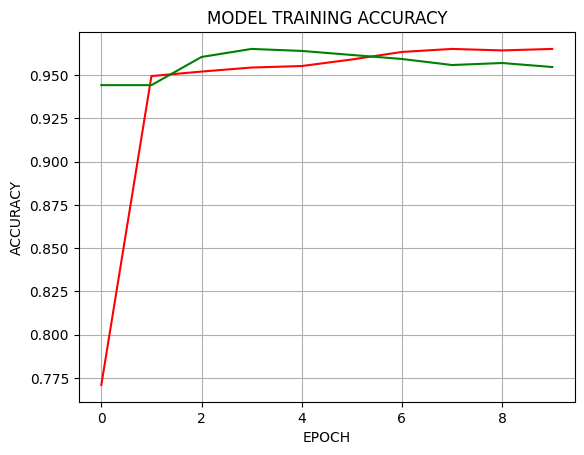

In [162]:
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='green')
plt.title('MODEL TRAINING ACCURACY')
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.grid()
plt.show()

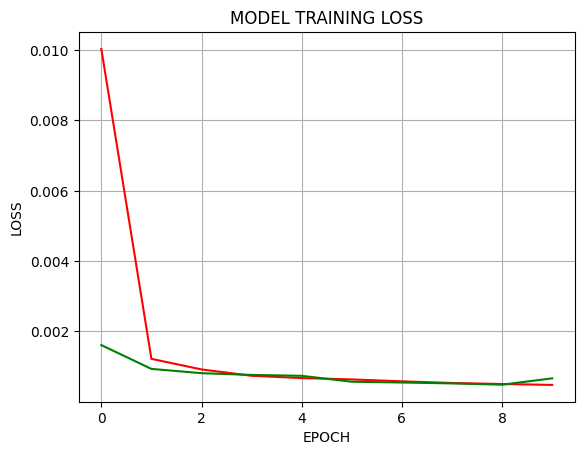

In [163]:
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.title('MODEL TRAINING LOSS')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.grid()
plt.show()

In [164]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

In [165]:
deep_prediction = ont_chat_model.predict(X_test)
# predicted_dnn = [np.argmax(pre) for pre in deep_prediction]
# dnn_ac = accuracy_score(y_test, predicted_dnn)
# dnn_pre = precision_score(y_test, predicted_dnn, average='weighted')
# dnn_rec = recall_score(y_test, predicted_dnn, average='weighted')
# dnn_f1 = f1_score(y_test, predicted_dnn, average='weighted')

# print(f'Accuracy {dnn_ac}, Precision {dnn_pre}, Recall {dnn_rec}, F1-score {dnn_f1}')
deep_prediction

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


array([[ 0.58538955,  0.39840263,  0.1611953 , ...,  0.07002048,
        -0.24285367, -0.13153897],
       [ 0.4564632 ,  0.21953414, -0.07575961, ..., -0.17160818,
        -0.30874643,  0.00723154],
       [ 0.47773048,  0.19476523, -0.20377788, ..., -0.21595338,
        -0.37043896,  0.05654525],
       ...,
       [ 0.4797882 ,  0.2678617 , -0.02073116, ..., -0.06161711,
        -0.30816603, -0.08956031],
       [ 0.36073884,  0.20179081, -0.02695872, ..., -0.04023362,
        -0.21992685, -0.04251913],
       [ 0.3872417 ,  0.18090472, -0.10061105, ..., -0.10746248,
        -0.27129057, -0.00270413]], dtype=float32)

In [166]:
mse = mean_squared_error(y_test, deep_prediction)
mae = mean_absolute_error(y_test, deep_prediction)

print(f'MSE : {mse} ==== MAE : {mae}')

MSE : 0.0006679788348264992 ==== MAE : 0.019853774458169937


In [54]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Compute similarity between actual and predicted responses
# def compute_accuracy(X_test, y_test, model):
#     correct = 0
#     total = len(X_test)

#     for i in range(total):
#         predicted_embedding = model.predict(np.array([X_test[i]]))[0]
#         actual_embedding = y_test[i]

#         # Compute cosine similarity
#         similarity = cosine_similarity([predicted_embedding], [actual_embedding])[0][0]

#         # Consider response correct if similarity > threshold (e.g., 0.8)
#         if similarity > 0.8:
#             correct += 1

#     return correct / total  # Accuracy

# # Example usage
# accuracy = compute_accuracy(X_train, y_train, ont_chat_model)
# print(f"Chatbot Accuracy: {accuracy:.2f}")


In [167]:
# saveing the deep learning model
ont_chat_model.save('chatbot_dnn.keras')
# Save the entire word2vec model
w2v.save("chatbot_word2vec.model")
print('model save')

model save


In [168]:
def load_ontology_models(dnn_model_path, w2vec_model_path):
    model = tf.keras.models.load_model(dnn_model_path)
    # model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    # load w2v..
    word2vec_model = Word2Vec.load(w2vec_model_path)
    return model, word2vec_model


dnn_model, vector_model = load_ontology_models("chatbot_dnn.keras" , "chatbot_word2vec.model")
dnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        15,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         6,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,712 (522.32 KB)

 Trainable params: 44,570 (174.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 89,142 (348.21 KB)

In [ ]:

# ================================================== WIKI PEDIA DOC PULLIN SYSTEM   STEP ONE ===========================================

import wikipediaapi

# Initialize the API
wiki = wikipediaapi.Wikipedia("ontology_project", "en")  # 'en' for English
# build a function version 
def getWiki_content(concepts): 
    # Initialize the API
    wiki = wikipediaapi.Wikipedia("ontology_project", "en")  # 'en' for English
    # Get a page, it as to pe a specific word
    concept_corpus = ''
    for concept in concepts:
        page = wiki.page(concept)
        # Check if the page exists
        if page.exists():
            # print("\nTitle:", page.title)
            # print("\nSummary:\n", page.summary[:])  # First 500 characters
            # print("\nFull Content:\n", page.text[:1000])  # First 1000 characters
            # print('CONCEPT : ', concept)
            concept_corpus = concept_corpus + '.\n' +  page.summary
        else:
            print("Page does not exist.")
            print('CONCEPT : ', concept)
            

    return concept_corpus


# ================================================== SPO PATTERN EXTRACTION   STEP TWO ===========================================

import spacy

# Load the English model
nlp = spacy.load("en_core_web_sm")

def get_full_predicate(token):
    """
    Build a full predicate phrase including auxiliaries, negations, and complements.
    """
    parts = [token.text]
    # Add auxiliary verbs and modifiers preceding the main verb
    parts.extend(child.text for child in token.children if child.dep_ in {"aux", "auxpass", "neg"})
    # Add complements or prepositional phrases following the main verb
    parts.extend(child.text for child in token.children if child.dep_ in {"prep", "xcomp", "acomp"})
    return " ".join(sorted(parts, key=lambda t: token.i))

def extract_svo_from_sentence(sentence):
    """
    Extract the subject, predicate (verb phrase), and object from a single sentence.
    """
    doc = nlp(sentence)
    subject, predicate, obj = None, None, None

    for token in doc:
        if "subj" in token.dep_:  # Identify the subject
            subject = token.text
        elif "ROOT" in token.dep_:  # Identify the verb (predicate)
            predicate = get_full_predicate(token)
        elif "obj" in token.dep_:  # Identify the object
            obj = token.text
    
    return subject, predicate, obj

def extract_svo_from_document(document):
    """
    Extract all SVO patterns from a multi-sentence document.
    """
    doc = nlp(document)
    results = []
    # print('DOCUMENT \n ======================================================== \n', doc)
    for sent in doc.sents:  # Iterate over sentences
        svo = extract_svo_from_sentence(sent.text)
        if any(svo):  # Only add non-empty results
            results.append(svo)
    
    return results


# ================================================== SPO FILTER PATTERN EXTRACTION   STEP THREE ===========================================
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
# Initialize the stemmer
stemmer = PorterStemmer()
stop_wrd = stopwords.words('english')

def stem_word(word):
    """
    Stems a word using the Porter Stemmer.
    """
    # print(word, type(word))
    return stemmer.stem(str(word).lower())

def filter_patterns_by_stemmed_intents(patterns, intents, stopword):

    # Stem all intents for comparison
    stemmed_intents = {stem_word(intent) for intent in intents}

    filtered_patterns = []

    for subject, predicate, obj in patterns:
        # Skip patterns containing None
        if None in (subject, predicate, obj):
            continue

        # Stem subject, predicate, and object for comparison
        stemmed_subject = stem_word(subject) if subject else ""
        stemmed_predicate = " ".join(stem_word(word) for word in predicate.split()) if predicate else ""
        stemmed_object = stem_word(obj) if obj else ""

        # Check if any stemmed part matches a stemmed intent
        if subject.lower() not in stop_wrd and obj.lower() not in stop_wrd:
            filtered_patterns.append((subject, predicate, obj))
            continue
        if stemmed_subject in stemmed_intents or \
           any(word in stemmed_intents for word in stemmed_predicate.split()) or \
           stemmed_object in stemmed_intents :
            
            filtered_patterns.append((subject, predicate, obj))
    

    return filtered_patterns


# ================================================== ONTOLOGY EVOLUTION EXTRACTION   STEP FOUR ===========================================

from owlready2 import *

def update_simple_sro_optimized(ontology_path, patterns, output_path):

    # Load the ontology
    onto = get_ontology(ontology_path).load()

    # Pre-cache ontology entities for faster lookup
    existing_classes = {cls.name: cls for cls in onto.classes()}
    existing_properties = {prop.name: prop for prop in onto.properties()}

    with onto:
        for domain, relationship, range_ in patterns:
            # Retrieve or create classes
            if domain in existing_classes:
                domain_class = existing_classes[domain]
            else:
                domain_class = types.new_class(domain, (Thing,))
                existing_classes[domain] = domain_class

            if range_ in existing_classes:
                range_class = existing_classes[range_]
            else:
                range_class = types.new_class(range_, (Thing,))
                existing_classes[range_] = range_class

            # Retrieve or create properties
            if relationship in existing_properties:
                rel_property = existing_properties[relationship]
            else:
                rel_property = types.new_class(relationship, (ObjectProperty,))
                existing_properties[relationship] = rel_property

            # Set domain and range (only if not already set)
            if not rel_property.domain:
                rel_property.domain = [domain_class]
            if not rel_property.range:
                rel_property.range = [range_class]

    # Save the updated ontology
    onto.save(file=output_path, format="rdfxml")
    print(f"Ontology updated and saved to {output_path}")


In [ ]:
# ================================================== QUERY SYSTEM ===========================================
# text = input('Engine : ')


def vector_to_sentence(vector, w2vec, top_n=5):
    # words = [w2vec.wv.most_similar(positive=[vector], topn=top_n)[i][0] for i in range(top_n)]
    words = w2vec.wv.most_similar(vector)
    print(words)
    return words



# Convert embedding to text
# response_sentence = vector_to_sentence(predicted_embedding, word2vec_model)
# print("Bot Response:", response_sentence)
# ================================== NEW FUNCTIONS ======================
# thtresholds
def pull_documents(input_vector):

    predicted_vector = dnn_model.predict(np.array([input_vector]))[0]
    print(f'Pre  : {predicted_vector}')

    vec_matching = cosine_similarity( np.expand_dims(predicted_vector, axis=0) , X )[0]

    index = []
    data = {}
    for i, prob in enumerate(vec_matching): 
        if (prob*100) > 99.7:
            index.append(i)
            data[i] = prob
    pull_doc = [mini_data.iloc[i].final_doc for i in index]
    data['pull_data'] = pull_doc

    return data



# @helper method : get candidate term
def get_candidate_term(query): 
    canditate_terms = ' '.join([txt for txt in query.split(' ') if txt not in stop_wrd])

    doc = nlp(canditate_terms)
    filtered_term = [d for d in doc if d.pos_ == 'NOUN']
    print(filtered_term)
    return filtered_term


# @helper method: getting if the candidate term is present in the vocabulary.. 
def word_to_vector_checker(list_term, w2v):
    candidate_terms_meta_data = {}
    for term in list_term: 
        term = w_lemmer.lemmatize(str(term))
        if  term in w2v.wv: 
            candidate_terms_meta_data[term] = True
        else:
            candidate_terms_meta_data[term] = False


    return candidate_terms_meta_data


# @ontology evolution action 
def ontology_evolution(evolved_term):
    
    print("\n\n============================== DOC EXTRACTION FROM WIKI ============================================")
    wiki_doc = getWiki_content(evolved_term[:])

    print("\n\n============================== SPO EXTRACTION ============================================\n")
    svo_patterns = extract_svo_from_document(wiki_doc)
    for idx, (subject, predicate, obj) in enumerate(svo_patterns, 1):
        print(f"Pattern {idx}: Subject: {subject}, Predicate: {predicate}, Object: {obj}")

    print("\n\n============================== SPO FILTER EXTRACTION ============================================\n")
    intents = filtered_term
    print('intents', intents)
    filtered_patterns = filter_patterns_by_stemmed_intents(svo_patterns, intents, stop_wrd)
    for idx, pattern in enumerate(filtered_patterns, 1):
        print(f"Pattern {idx}: {pattern}")


    print("\n\n============================== ONTOLOGY EVOLUTION  ============================================\n")
    ontology_path = "evolved_macconto.owl"  # Replace with your OWL file path
    output_path = "evolved_macconto.owl"  # File to save the updated ontology
    # update_simple_sro_optimized(ontology_path, filtered_patterns, output_path)
    print('ONTOLOGY EVOLUTION')



def BOTmodel_prediction(query): 
    
    input_vector = sentence_to_vector(query, w2v)
    data = pull_documents(input_vector)

    if data['pull_data'] == []: 
        print('Initiate Ontology Evolution')
        candidate_terms = get_candidate_term(query)
        term_metadata = word_to_vector_checker(candidate_terms, w2v)
        print(term_metadata)

        # collect single or multi-concept to be evolved...  
        evolved_terms = []
        for term, term_condition in term_metadata.items(): 
            if not term_condition: 
                evolved_terms.append(term)
        
        # ACTIVATING EVOLUTION OR NOT... 
        if evolved_terms != []: 
            print(f'Ontology Evolution on Evolved Term : {evolved_terms}')
            wiki_doc = ontology_evolution(evolved_terms)

        else: 
            print('No suitable responce on your search.... thanks!')

       


query = 'what is fertilizers, hoe, and machete'
# query = 'what is fertilizers'

BOTmodel_prediction(query)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
Pre  : [ 0.59360224  0.30615726 -0.09148387 -0.22482671 -0.12720753 -0.53347486
  0.17902027  0.72978854  0.02157548 -0.04089863 -0.02251309 -0.13286515
  0.24704188 -0.04236649  0.36675674 -0.10903524  0.08569145 -0.3661829
  0.02881868 -0.4493214   0.4059201   0.13905856  0.0251572   0.01527484
  0.39222595 -0.13977723 -0.26504868  0.03624655  0.43642524  0.20537001
  0.28614038  0.25041318  0.02387196 -0.09199603 -0.3969314   0.28068274
 -0.15979336  0.04056583  0.46585461  0.0841007   0.6577966   0.01290437
  0.00544377 -0.03795952  0.40235326 -0.12380954 -0.08079611 -0.04059574
 -0.3614082  -0.07062761]
Initiate Ontology Evolution
[fertilizers, hoe, machete]
{'fertilizer': True, 'hoe': False, 'machete': False}
Ontology Evolution on Evolved Term : ['hoe', 'machete']


============================== DOC EXTRACTION FROM WIKI ============================================
.
Hoe or HOE may refer to:

Hoe (food), a Korean dish of raw fish
Hoe (letter

In [311]:
# dataset.head(2)

In [320]:
mini_data = dataset[['final_doc', 'questions']]
data_questions = mini_data.questions.tolist()
data_questions[:4]

['What is the impact of fertilizers affects corn?',
 'How does fertilizers affects corn affect agriculture?',
 'Why is fertilizers affects corn important?',
 'What are the benefits of fertilizers affects corn?']

#### Evaluation 

In [354]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score


# @HELPER METHOD TO COMPUTE ACCURACY
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Convert to percentage



# @helper method to evaluate the predicted answer and expected answer
def model_evaluation(query, question, w2v):

    input_vector = sentence_to_vector(query, w2v)
    expected_vector = sentence_to_vector(question, w2v)
    predicted_vector = dnn_model.predict(np.array([input_vector]))[0]
    vec_matching = cosine_similarity( np.expand_dims(predicted_vector, axis=0) , X )[0]
    max_maching = np.argmax(vec_matching)
    
    pulled_row = mini_data.iloc[max_maching]
    ml_responce = pulled_row.final_doc

    mse = mean_squared_error(expected_vector, predicted_vector)
    mae = mean_absolute_error(expected_vector, predicted_vector)
    rsquare = r2_score(expected_vector, predicted_vector)
    mape = mean_absolute_percentage_error(expected_vector, predicted_vector) * 100
    print(f'MSE: {mse:.4f}' )
    print(f'MAE: {mae:.4f}')
    print(f'R2 error: {rsquare:.4f}')
    print(f'MAPE: {mape:.4f}%')


    


    return  ml_responce, mse, mae, rsquare, mape 





final_results = {
    'ex_respond':[], 
    'ml_respond':[], 
    'MSE':[], 
    'MAE':[], 
    'r2_score':[], 
    'MAPE':[]
}

for index in range(mini_data.shape[0])[:50]:
    query = mini_data.questions.tolist()[index]
    expected_responce = mini_data.final_doc.tolist()[index]
    data = model_evaluation(query, expected_responce, w2v)
    print(f'Query : {query}')
    print(f'EXP Responce : {expected_responce}')
    print(f'ML Responce : {data[0]}')

    final_results['ex_respond'].append(expected_responce)
    final_results['ml_respond'].append(data[0])
    final_results['MSE'].append(data[1])
    final_results['MAE'].append(data[2])
    final_results['r2_score'].append(data[3])
    final_results['MAPE'].append(data[4])
    print('==========================================')


result_table = pd.DataFrame(final_results)
result_table.head(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
MSE: 0.0035
MAE: 0.0467
R2 error: 0.9310
MAPE: 71.1984%
Query : What is the impact of fertilizers affects corn?
EXP Responce : fertilizers affects corn
ML Responce : organic fertilizers is the most suitable organic fertilizers for cultivating maize crop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
MSE: 0.0012
MAE: 0.0278
R2 error: 0.9765
MAPE: 41.5449%
Query : How does fertilizers affects corn affect agriculture?
EXP Responce : fertilizers affects corn
ML Responce : inorganic fertilizers are available inorganic fertilizers for maize crop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
MSE: 0.0013
MAE: 0.0279
R2 error: 0.9741
MAPE: 50.0263%
Query : Why is fertilizers affects corn important?
EXP Responce : fertilizers affects corn
ML Responce : organic fertilizers is the most suitable organic fertilizers for cultivating maize crop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
MSE: 0.0024
MAE: 0.0401
R2 error: 0.9527
MAPE: 56.1320%
Query : What are the benefits of fertilizers

,ex_respond,ml_respond,MSE,MAE,r2_score,MAPE
0,fertilizers affects corn,organic fertilizers is the most suitable organ...,0.003504,0.046695,0.930990,71.198380
1,fertilizers affects corn,inorganic fertilizers are available inorganic ...,0.001191,0.027790,0.976544,41.544864
2,fertilizers affects corn,organic fertilizers is the most suitable organ...,0.001317,0.027855,0.974063,50.026339
3,fertilizers affects corn,organic fertilizers are available organic fert...,0.002402,0.040130,0.952702,56.131995
4,fertilizers affects corn,inorganic fertilizers is the most suitable ino...,0.002123,0.038634,0.958180,50.053483
5,fertilizers affects crop,fertilizers are available fertilizers for maiz...,0.003202,0.044772,0.950169,76.460272
6,fertilizers affects crop,inorganic fertilizers is the most suitable ino...,0.000996,0.024810,0.984506,31.762603
7,fertilizers affects crop,organic fertilizers is the most suitable organ...,0.001513,0.030859,0.976454,50.682497
8,fertilizers affects crop,fertilizers are available fertilizers for maiz...,0.002169,0.037171,0.966251,53.854156
9,fertilizers affects crop,inorganic fertilizers is the most suitable ino...,0.001372,0.029599,0.978645,39.965028


<Axes: >

<Figure size 400x1500 with 0 Axes>

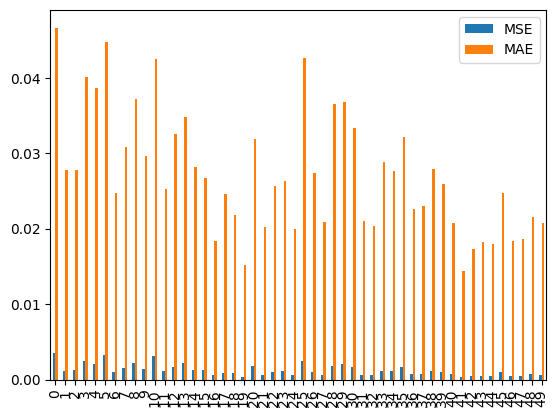

In [371]:
plt.figure(figsize=(4,15))
result_table[['MSE', 'MAE']].plot(kind='bar')


<BarContainer object of 50 artists>

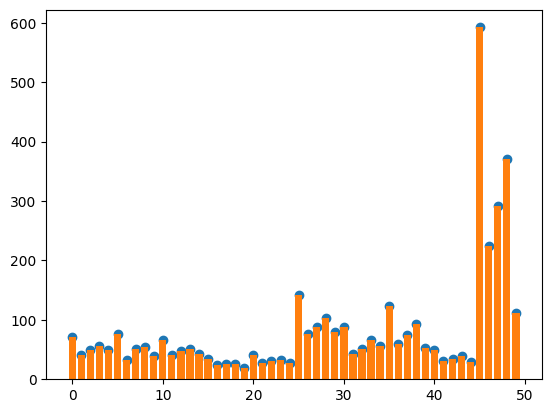

In [ ]:
plt.scatter( np.arange(50) , result_table['MAPE'].values)
plt.bar(np.arange(50), result_table['MAPE'].values)

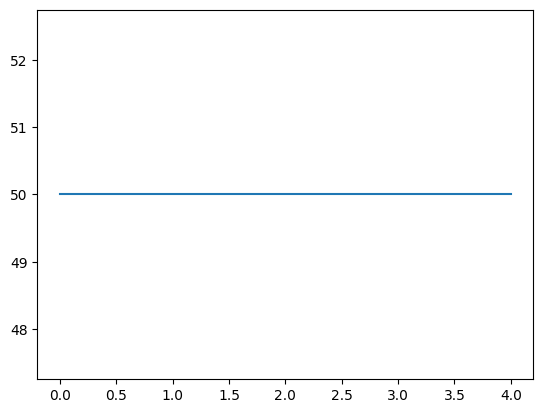

In [404]:
plt.plot([50]*5)

In [388]:
q_number = [f'Q{i}' for i in np.arange(50)]

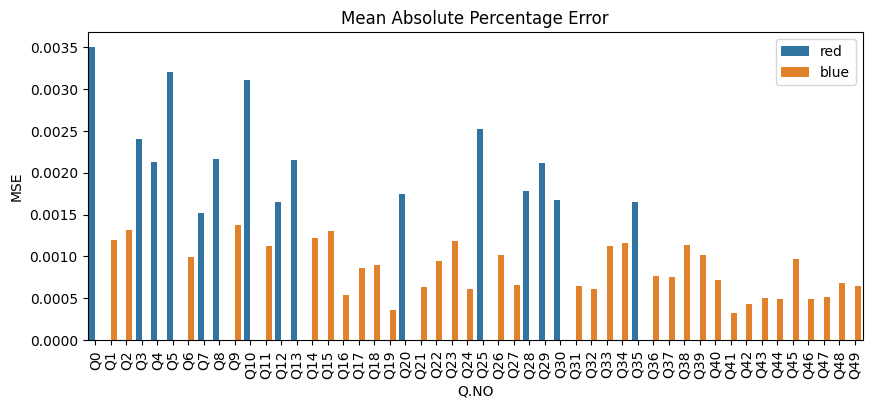

In [421]:
import seaborn as sn


plt.figure(figsize=(10, 4))
result_table['color'] = result_table['MSE'].apply(lambda x: 'red' if x>0.0015 else 'blue')
result_table['Q.NO'] = q_number
sn.barplot(x='Q.NO' , y='MSE', data=result_table,  hue=result_table.color.tolist())
plt.xticks(rotation=90)
# plt.legend()
plt.title('Mean Absolute Percentage Error')
# plt.grid()
plt.show()

In [422]:
result_table.to_csv('experimental_result.csv')
print('result saved... ')

result saved... 


In [341]:
range(mini_data.shape[0])[:5]


range(0, 5)

In [242]:
from sklearn.metrics.pairwise import cosine_similarity

sample_vec = sentence_to_vector('what is fertilizer', w2v)

predicted_vector = dnn_model.predict(np.array([sample_vec]))[0]
print(f'Pre  : {predicted_vector}')

vec_matching = cosine_similarity( np.expand_dims(predicted_vector, axis=0) , X )[0]
# X.shape

# X[1] == sentence_to_vector('How does fertilizers affects corn affect agriculture?', w2v)
match_loc = np.argmax(vec_matching)
print(f'Consine Similarity Score:  {vec_matching[match_loc]}')
dataset[['final_doc', 'questions']].iloc[match_loc].final_doc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Pre  : [ 0.6632005   0.40219808  0.05377751 -0.07213833  0.0492484  -0.44548136
  0.21348299  0.59754086 -0.03522669 -0.18674727 -0.09148119 -0.16657192
  0.10298596 -0.12196308  0.50859    -0.21020941  0.15870845 -0.6655039
  0.13076352 -0.31877524  0.27692795  0.14471409 -0.26587486 -0.05499468
  0.21334831 -0.08311596 -0.33547044  0.12715027  0.58074147  0.25423777
  0.28050297  0.18061066  0.15895027 -0.0814997  -0.31110334  0.26380825
 -0.32460168  0.03708588  0.49288887  0.14545898  0.59016925  0.15822704
 -0.03334723 -0.1350547   0.26991245 -0.12227855 -0.07613461 -0.00118318
 -0.26554322 -0.07041159]
Consine Similarity Score:  0.9842318296432495


'fertilizers has to be applied with precaution fertilizer application precautions'

In [223]:
mini_data = dataset[['final_doc', 'questions']]

In [263]:
w_lemmer.lemmatize('fertilizers')

'fertilizer'

In [ ]:
query = 'what is fertilizers, hoe, and cultlas'
input_vector = sentence_to_vector(query, w2v)


# thtresholds
def pull_documents(input_vector):

    predicted_vector = dnn_model.predict(np.array([input_vector]))[0]
    print(f'Pre  : {predicted_vector}')

    vec_matching = cosine_similarity( np.expand_dims(predicted_vector, axis=0) , X )[0]

    index = []
    data = {}
    for i, prob in enumerate(vec_matching): 
        if (prob*100) > 99.7:
            index.append(i)
            data[i] = prob
    pull_doc = [mini_data.iloc[i].final_doc for i in index]
    data['pull_data'] = pull_doc

    return data

data = pull_documents(input_vector)
data


# @helper method : get candidate term
def get_candidate_term(query): 
    canditate_terms = ' '.join([txt for txt in query.split(' ') if txt not in stop_wrd])

    doc = nlp(canditate_terms)
    filtered_term = [d for d in doc if d.pos_ == 'NOUN']
    print(filtered_term)
    return filtered_term


# @helper method: getting if the candidate term is present in the vocabulary.. 
def word_to_vector_checker(list_term, w2v):
    candidate_terms_meta_data = {}
    for term in list_term: 
        term = w_lemmer.lemmatize(str(term))
        if  term in w2v.wv: 
            candidate_terms_meta_data[term] = True
        else:
            print('not in vocab')
            candidate_terms_meta_data[term] = False


    return candidate_terms_meta_data


# checking if what is pull is []
if data['pull_data'] == []: 
    print('Initiate Ontology Evolution')
    candidate_terms = get_candidate_term(query)
    term_metadata = word_to_vector_checker(candidate_terms, w2v)
    print(term_metadata)
    
    # loop through metada and initiate ontology evolution


    # checking if the word exist in a word level vocab 



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Pre  : [ 0.59360224  0.30615726 -0.09148387 -0.22482671 -0.12720753 -0.53347486
  0.17902027  0.72978854  0.02157548 -0.04089863 -0.02251309 -0.13286515
  0.24704188 -0.04236649  0.36675674 -0.10903524  0.08569145 -0.3661829
  0.02881868 -0.4493214   0.4059201   0.13905856  0.0251572   0.01527484
  0.39222595 -0.13977723 -0.26504868  0.03624655  0.43642524  0.20537001
  0.28614038  0.25041318  0.02387196 -0.09199603 -0.3969314   0.28068274
 -0.15979336  0.04056583  0.46585461  0.0841007   0.6577966   0.01290437
  0.00544377 -0.03795952  0.40235326 -0.12380954 -0.08079611 -0.04059574
 -0.3614082  -0.07062761]
Initiate Ontology Evolution
[fertilizers, hoe, cultlas]
not in vocab
not in vocab
{'fertilizer': True, 'hoe': False, 'cultlas': False}


In [205]:
dataset.final_doc

2                           fertilizers affects corn
2                           fertilizers affects corn
2                           fertilizers affects corn
2                           fertilizers affects corn
2                           fertilizers affects corn
                            ...                     
1666    irrigation methods suitable for maize string
1666    irrigation methods suitable for maize string
1666    irrigation methods suitable for maize string
1666    irrigation methods suitable for maize string
1666    irrigation methods suitable for maize string
Name: final_doc, Length: 4300, dtype: object

In [191]:
dataset[['final_doc', 'questions']].iloc[match_loc].questions

'What is the impact of manures is harmless to crop string?'

In [98]:
np.expand_dims(sample_vec, axis=0).shape

(1, 50)

In [174]:
dataset[['final_doc', 'questions']].iloc[10]

final_doc                           fertilizers affects maize
questions    What is the impact of fertilizers affects maize?
Name: 4, dtype: object

In [310]:
sample_q

['Why is maize has parts maize growth parts important?',
 'What is the impact of soils state of fertilitycan be determined by test soil fertility test?',
 'What challenges are associated with soils has soil quality metric soil quality metrics?',
 'How does soils is used to grow maize grass affect agriculture?',
 'What is the impact of insecticide treatments is used for the treatment of worm or pest pests?',
 'Why is maize factor has wide float important?']